In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Pirmiausia turime apdoroti duomenis į pytorch datasetą

In [19]:
class ShapesDataSet(Dataset):
    
    def __init__(self, images_array, labels_array, transform=None):
        super().__init__()
        
        self.x = torch.from_numpy(images_array).float()
        self.y = torch.from_numpy(labels_array).long()
        
        self.transform = transform
        self.x = self.transform(self.x)
        
    # Kad žinotumėme dataseto ilgį
    def __len__(self):
        return self.x.shape[0]
    
    # Kad galėtumėme išsiimti bet kurį elementą iš dataseto
    def __getitem__(self, idx):
        img_tensor = self.x[idx]
        
        # Jei reikia, naudojame transformacijas
        if self.transform:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, self.y[idx]

Sukuriame pagrindinę neuroninio modelio klasę

In [20]:
class ShapesNet(nn.Module):
    
    def __init__(self, n_classes):
        super(ShapesNet, self).__init__()
        
        # Sukuriami konvoliuciniai sluoksniai
        self.conv_1 = nn.Conv2d(in_channels=1, 
                                out_channels=4, 
                                kernel_size=5, 
                                stride=2, 
                                padding=1)
        self.conv_2 = nn.Conv2d(in_channels=4, 
                                out_channels=8, 
                                kernel_size=3, 
                                stride=2, 
                                padding=1)
        self.conv_3 = nn.Conv2d(in_channels=8, 
                                out_channels=16, 
                                kernel_size=3, 
                                stride=2, 
                                padding=1)
        
        # Sukuriami normalizacijos sluoksniai batch'ams
        self.bn_1 = nn.BatchNorm2d(num_features=4)
        self.bn_2 = nn.BatchNorm2d(num_features=8)
        self.bn_3 = nn.BatchNorm2d(num_features=16)
        self.bn_4 = nn.BatchNorm1d(num_features=100)
        
        # Sukuriami linijiniai sluoksniai
        self.fc_1 = nn.Linear(in_features=16 * 6 * 6,
                                out_features=100)
        self.fc_out = nn.Linear(in_features=100,
                                out_features=n_classes)
        
    # Metodas, skirtas paskaičiuoti modelio outputą
    def forward(self, x):
        x = self.bn_1(F.leaky_relu(self.conv_1(x)))
        x = self.bn_2(F.leaky_relu(self.conv_2(x)))
        x = self.bn_3(F.leaky_relu(self.conv_3(x)))
        x = self.bn_4(F.leaky_relu(self.fc_1(torch.reshape(x, (-1, 16 * 6 * 6)))))
        
        return self.fc_out(x)

Užsikrauname failą ir apdorojame duomenis

In [21]:
# Užsikrauname failą
data = np.load('flatland_train.npz')
x = data['X']
y = data['y']

# Padarome kad klasės būtų nuo 0 iki 4
y = y - 2
y[y < 0] = 0

# Išskiriam duomenis iš train test imtis
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)

# Sukuriam transformacijos objektą
transform = transforms.Compose([transforms.Normalize((0.5), (0.5))])

# Sukuriam datasetai iš numpy arrays
shapes_trainset = ShapesDataSet(x_train, 
                                y_train, 
                                transform=transform)
shapes_testset = ShapesDataSet(x_test, 
                               y_test, 
                               transform=transform)

# Sukuriam dataloaderius, kurie bus naudojami modelio mokyme
shapes_dataloader_train = DataLoader(shapes_trainset,
                                     batch_size=100,
                                     shuffle=True)
shapes_dataloader_test = DataLoader(shapes_testset,
                                     batch_size=1,
                                     shuffle=True)

Galime sukurti norimo image atvaizdavimo funkciją ir jį atvaizduoti:

In [22]:

def plot_image(image_array):
    plt.imshow(image_array, cmap='gray')

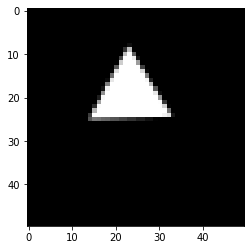

In [23]:
# Atvaizduojamas bet koks image iš dataseto
idx = 5000
image_array = x_train[idx].reshape(50, 50)
plot_image(image_array)

Galime paskaičiuoti, kiek unikalių reikšmių turės modelis

In [24]:
n_classes = len(np.unique(y))
np.unique(y)

array([0., 1., 2., 3., 4.])

Apibrėžiame modelio treniravimui reikalingas reikšmes

In [25]:
# Kadangi naudojamos konvoliucijos, tai pasižiūrima, ar galima bus naudoti GPU, o ne CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
# Inicializuojama klasė
shapes_net = ShapesNet(n_classes).to(device)


In [28]:
# Nurodoma, kiek bus epochų
n_epochs = 10
# Inicializuojamas optimizuotojas
optim = torch.optim.AdamW(shapes_net.parameters(),
                          lr=0.001)
# Inicializuojama loss funkcija
criterion = nn.CrossEntropyLoss()

Dabar galime pereiti prie modelio treniravimo

In [29]:
for epoch in range(n_epochs):
    # Sukuriami kintamieji, kurie savyje laikys treniravimo rezultatus
    total_loss_train = 0
    total_loss_valid = 0
    train_correct_preds = 0
    valid_correct_preds = 0
    
    # Nurodoma, kad modelis bus treniravimo rėžime
    shapes_net.train()
    
    # 1-os epochos modelio mokymo loop'as
    for images, labels in shapes_dataloader_train:
        # Images and labels užkraunami į nurodytą device
        images = images.to(device)
        labels = labels.to(device)
        
        # Nunulinami gradientai, kadangi pytorch jų nenunulina (jei šios funkcijos nenaudotume, tai gradientai būtų be sustojimo kaupiami)
        optim.zero_grad()
        # Gaunami modelio spėjimai
        preds = shapes_net(images)
        
        train_correct_preds += torch.argmax(preds, dim=1).eq(labels).sum().item()
        
        # Paskaičiuojamas modelio loss'as
        loss = criterion(preds, labels)
        # Paskaičiuojami modelio gradientai pagal loss'ą
        loss.backward()
        # Paupdatinami modelio parametrai pagal gradientus
        optim.step()
        
    shapes_net.eval()
    
    #  Modelio rezultatų atvaizdavimui vizualiai 
    with torch.no_grad():
        for images, labels in shapes_dataloader_test:
            images = images.to(device)
            labels = labels.to(device)

            preds = shapes_net(images)
            valid_correct_preds += torch.argmax(preds, dim=1).eq(labels).sum().item()

            loss = criterion(preds, labels)
            
    train_binary_accuracy_pct = round(train_correct_preds / len(shapes_dataloader_train.dataset) * 100, 2)
    valid_binary_accuracy_pct = round(valid_correct_preds / len(shapes_dataloader_test.dataset) * 100, 2)
        
    print(f'Epoch: {epoch + 1}, training set accuracy: {train_binary_accuracy_pct}%, Validation set accuracy: {valid_binary_accuracy_pct}%')

Epoch: 1, training set accuracy: 50.7%, Validation set accuracy: 60.5%
Epoch: 2, training set accuracy: 68.97%, Validation set accuracy: 70.2%
Epoch: 3, training set accuracy: 79.17%, Validation set accuracy: 75.2%
Epoch: 4, training set accuracy: 84.88%, Validation set accuracy: 81.1%
Epoch: 5, training set accuracy: 89.54%, Validation set accuracy: 84.9%
Epoch: 6, training set accuracy: 93.51%, Validation set accuracy: 88.55%
Epoch: 7, training set accuracy: 95.25%, Validation set accuracy: 89.85%
Epoch: 8, training set accuracy: 96.95%, Validation set accuracy: 90.75%
Epoch: 9, training set accuracy: 97.55%, Validation set accuracy: 91.55%
Epoch: 10, training set accuracy: 98.31%, Validation set accuracy: 92.05%


Išsaugome modelį:

In [30]:
model = shapes_net
torch.save(model, 'model.h5')